In [1]:
import tensorflow as tf
import tensorflow.keras as keras
import numpy as np
import matplotlib.pyplot as plt
import os
import datetime

In [2]:
tf.random.set_seed(42)
np.random.seed(42)

In [3]:
print(tf.config.list_physical_devices())

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [4]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

In [5]:
print(f"Train set size is {len(x_train)}.")
print(f"Test set size is {len(x_test)}.")

Train set size is 60000.
Test set size is 10000.


In [6]:
x_train.shape, y_train.shape

((60000, 28, 28), (60000,))

In [7]:
def decode_label(one_hots):
    return int(tf.argmax(one_hots, axis=0))

y_train = tf.one_hot(y_train, 10)
y_test = tf.one_hot(y_test, 10)

In [8]:
def preprocess(img):
    img = np.where(img == 0, 0., 1.)
    return img[..., np.newaxis]

x_train = preprocess(x_train)
x_test = preprocess(x_test)

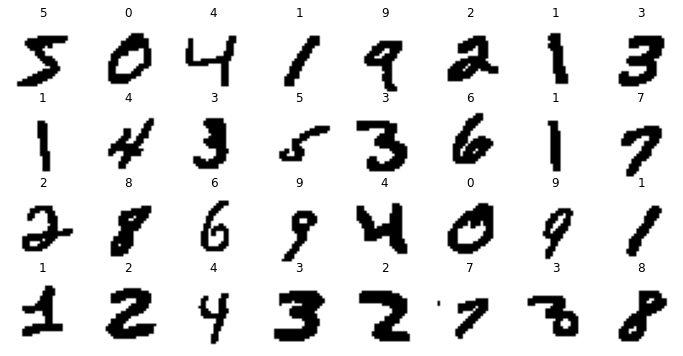

In [9]:
BATCH_SIZE = 32

def plot_batch(x, y):
    i = 1
    plt.figure(figsize=(12, 6))
    for sample_x, sample_y in zip(x[:BATCH_SIZE], y[:BATCH_SIZE]):
        plt.subplot(4, 8, i)
        plt.imshow(sample_x, cmap="binary")
        plt.title(decode_label(sample_y))
        plt.axis("off")
        i += 1
    plt.show()

plot_batch(x_train, y_train)

In [10]:
# load samples
id_ = 0

x_custom_test = y_custom_test = None
while id_ < 100:
    path = os.path.join("samples", f"sample_{id_}.npy")
    sample = np.load(path)
    target = id_ % 10
    sample = sample[np.newaxis, ...]

    if x_custom_test is not None:
        x_custom_test = np.r_[x_custom_test, sample]
        y_custom_test = np.r_[y_custom_test, target]
    else:
        x_custom_test = sample
        y_custom_test = target
    id_ += 1

x_custom_test = x_custom_test[..., np.newaxis]
y_custom_test = tf.one_hot(y_custom_test, 10)

In [11]:
x_custom_test.shape, y_custom_test.shape

((100, 28, 28, 1), TensorShape([100, 10]))

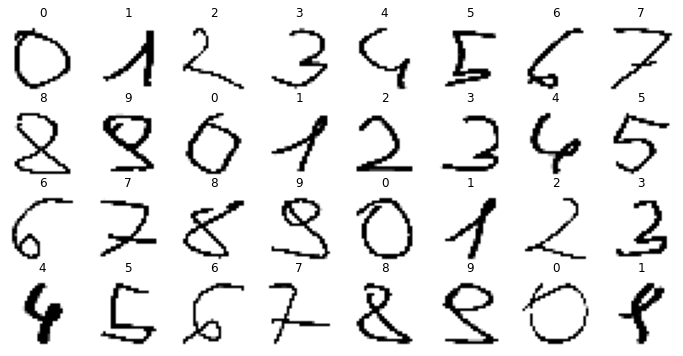

In [12]:
plot_batch(x_custom_test, y_custom_test)

In [13]:
# user might have not write them straight
datagen = keras.preprocessing.image.ImageDataGenerator(
    rotation_range=20,
)

train_gen = datagen.flow(x_train, y_train, batch_size=BATCH_SIZE)
test_gen = datagen.flow(x_test, y_test, batch_size=BATCH_SIZE)
# custon_test_gen = datagen.flow(x_custom_test, y_custom_test, batch_size=BATCH_SIZE)

In [14]:
model = keras.models.Sequential([
    keras.layers.Input(shape=[28, 28, 1]),

    keras.layers.Conv2D(64, kernel_size=3, padding="same"),
    keras.layers.LeakyReLU(),
    keras.layers.Conv2D(64, kernel_size=3, padding="same"),
    keras.layers.LeakyReLU(),
    keras.layers.MaxPool2D(pool_size=2, padding="same"),
    keras.layers.BatchNormalization(),

    keras.layers.Conv2D(128, kernel_size=3, padding="same"),
    keras.layers.LeakyReLU(),
    keras.layers.Conv2D(128, kernel_size=3, padding="same"),
    keras.layers.LeakyReLU(),
    keras.layers.MaxPool2D(pool_size=2, padding="same"),
    keras.layers.BatchNormalization(),

    keras.layers.Conv2D(256, kernel_size=3, padding="same"),
    keras.layers.LeakyReLU(),
    keras.layers.Conv2D(256, kernel_size=3, padding="same"),
    keras.layers.LeakyReLU(),
    keras.layers.MaxPool2D(pool_size=2, padding="same"),
    keras.layers.BatchNormalization(),

    keras.layers.Conv2D(512, kernel_size=3),
    keras.layers.LeakyReLU(),
    keras.layers.AvgPool2D(pool_size=2),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.4),

    keras.layers.Flatten(),
    keras.layers.Dense(512),
    keras.layers.LeakyReLU(),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(256),
    keras.layers.LeakyReLU(),
    keras.layers.Dense(10, activation="softmax"),
])

In [15]:
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

In [16]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 64)        640       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 28, 28, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 64)        36928     
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 28, 28, 64)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 64)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 14, 14, 64)        256       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 128)       7

In [17]:
MODEL_FILE = "model4.h5"

log_dir = os.path.join(os.curdir, "logs", datetime.datetime.now().strftime("%Y-%m-%d_%H.%M.%S"))

tensorbord_cb = keras.callbacks.TensorBoard(log_dir=log_dir, write_steps_per_second=True, histogram_freq=1, write_images=True, update_freq=10000)
earlystop_cb = keras.callbacks.EarlyStopping(patience=10, mode="max", verbose=1)
save_cb = keras.callbacks.ModelCheckpoint(MODEL_FILE, save_best_only=True, verbose=1)
rp_cb = keras.callbacks.ReduceLROnPlateau(patience=3, mode="max", min_lr=0.00001, verbose=1)

callbacks = [tensorbord_cb, earlystop_cb, save_cb, rp_cb]

In [18]:
TRAIN_STEPS = len(x_train) // BATCH_SIZE
VALID_STEPS = len(x_test) // BATCH_SIZE

# with tf.device('GPU:0'): # use gpu
history = model.fit(
    train_gen,
    validation_data=test_gen, 
    steps_per_epoch=TRAIN_STEPS, validation_steps=VALID_STEPS,
    epochs=100, callbacks=callbacks) # 100 epochs because it will stop earlier by callback

Epoch 1/100
1875/1875 [==============================] - 45s 21ms/step - loss: 0.2039 - accuracy: 0.9418 - val_loss: 0.0929 - val_accuracy: 0.9728

Epoch 00001: val_loss improved from inf to 0.09291, saving model to model4.h5
Epoch 2/100
1875/1875 [==============================] - 42s 22ms/step - loss: 0.1097 - accuracy: 0.9684 - val_loss: 0.1329 - val_accuracy: 0.9597

Epoch 00002: val_loss did not improve from 0.09291
Epoch 3/100
1875/1875 [==============================] - 36s 19ms/step - loss: 0.0923 - accuracy: 0.9734 - val_loss: 0.0625 - val_accuracy: 0.9832

Epoch 00003: val_loss improved from 0.09291 to 0.06251, saving model to model4.h5
Epoch 4/100
1875/1875 [==============================] - 37s 20ms/step - loss: 0.0774 - accuracy: 0.9779 - val_loss: 0.0991 - val_accuracy: 0.9714

Epoch 00004: val_loss did not improve from 0.06251
Epoch 5/100
1875/1875 [==============================] - 37s 20ms/step - loss: 0.0735 - accuracy: 0.9785 - val_loss: 0.0471 - val_accuracy: 0.9863

In [19]:
%load_ext tensorboard

In [20]:
model.save("final_model4.h5") # save last model as well

In [21]:
model.evaluate(x_custom_test, y_custom_test)

4/4 [==============================] - 1s 63ms/step - loss: 1.6185 - accuracy: 0.6500


[1.6184790134429932, 0.6499999761581421]

In [22]:
best_model = keras.models.load_model("model4.h5")

In [23]:
best_model.evaluate(x_custom_test, y_custom_test)

4/4 [==============================] - 0s 6ms/step - loss: 1.6185 - accuracy: 0.6500


[1.6184790134429932, 0.6499999761581421]

In [24]:
keras.backend.clear_session()